In [18]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [19]:
# Load Data and Preprocess
def load_data(filepath):
    df = pd.read_csv(filepath, sep=',')  # Load dataset

    # Encode categorical columns
    cat_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome','y']
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    X = df.drop('y', axis=1).values  # Features only

    # Standard Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df


#================ FOR PCA Dimensionality Reduction =========
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x)

    # Plot Explained Variance
    plt.figure(figsize=(6,4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Variance Explained")
    plt.show()

    return x_pca


#================ FOR K-Means ===============================
def find_optimal_clusters(x, max_clusters=10):
    inertia = []
    for k in range(1, max_clusters+1):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(x)
        inertia.append(km.inertia_)

    plt.figure(figsize=(6,4))
    plt.plot(range(1, max_clusters+1), inertia, marker='o')
    plt.title("Elbow Method for Choosing k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.show()

    return inertia


def perform_kmeans_clustering(x, n_clusters=None):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(x)

    plt.scatter(x[:,0], x[:,1], c=labels, cmap='viridis')
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=200, marker='X')
    plt.title(f"K-Means Clustering with k={n_clusters}")
    plt.show()

    return labels


#================ FOR Agglomerative ===============================
def perform_agglomerative_clustering(x, n_clusters=None):
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg.fit_predict(x)

    plt.scatter(x[:,0], x[:,1], c=labels, cmap='viridis')
    plt.title(f"Agglomerative Clustering with k={n_clusters}")
    plt.show()

    return labels


#================ FOR Dendrogram ===============================
def get_linkages(x):
    linked = linkage(x, method='ward')
    return linked


def plot_dendrogram(linked):
    plt.figure(figsize=(10,5))
    dendrogram(linked)
    plt.title("Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()


## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

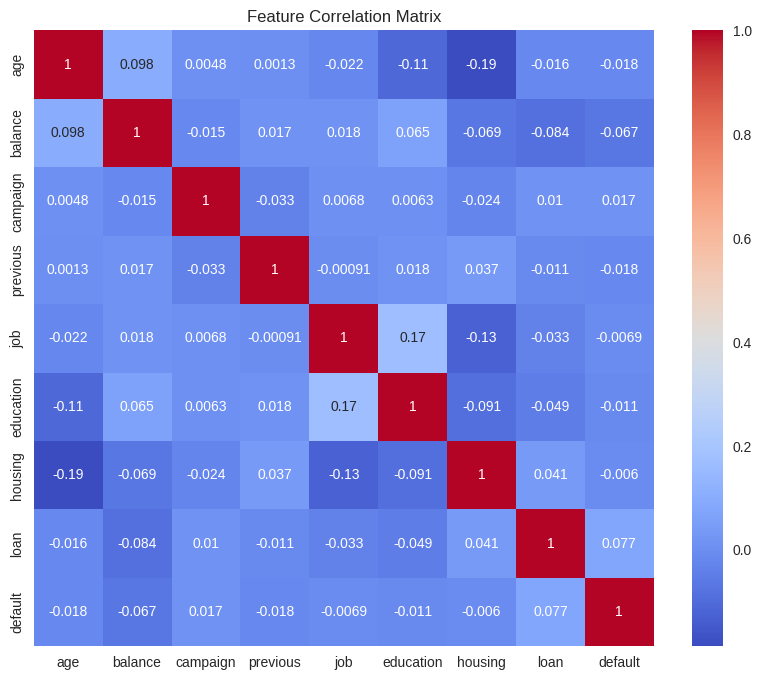

Data shape: (45211, 9)


In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

def load_data(filepath):
    """Load and preprocess the bank marketing dataset."""

    # Load data correctly (semicolon separated)
    df = pd.read_csv(filepath, sep=',')

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                        'loan', 'contact', 'month', 'poutcome', 'y']

    # Apply label encoding
    encoder = LabelEncoder()
    for col in categorical_cols:
        df[col] = encoder.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
                'housing', 'loan', 'default']
    X = df[features].values

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    plt.figure(figsize=(10, 8))
    sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    plt.show()

    return X_scaled, df

# Load and preprocess data
X_scaled, data = load_data("bank-full.csv")
print("Data shape:", X_scaled.shape)


In [9]:
import numpy as np

class KMeansClustering:
    """Minimal K-means skeleton for students to implement."""

    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Randomly select `n_clusters` distinct points from X as initial centroids."""
        np.random.seed(self.random_state)
        indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[indices]
        return self.centroids

    def _assign_clusters(self, X):
        """Assign each sample to the nearest centroid using Euclidean distance."""
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster."""
        new_centroids = []
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids.append(cluster_points.mean(axis=0))
            else:
                # If a cluster gets no points, keep the old centroid
                new_centroids.append(self.centroids[k])
        return np.array(new_centroids)

    def fit(self, X):
        """Run K-means until convergence or max_iters."""
        # Initialize centroids
        self._initialize_centroids(X)

        for _ in range(self.max_iters):
            # Assign clusters
            labels = self._assign_clusters(X)

            # Update centroids
            new_centroids = self._update_centroids(X, labels)

            # Stop if converged (no meaningful change)
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        self.labels = labels
        return self

    def predict(self, X):
        """Assign cluster labels to X using learned centroids."""
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)


## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

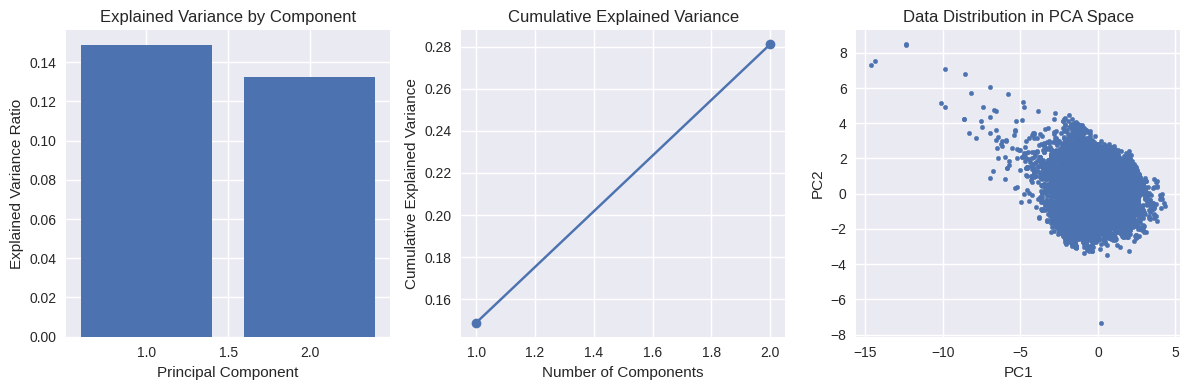

Shape after PCA: (45211, 2)


In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction."""

    # 1. Initialize and fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # 2. Create visualization
    plt.figure(figsize=(12, 4))

    # Plot 1: Explained Variance Ratio
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_)
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance by Component")

    # Plot 2: Cumulative Explained Variance
    plt.subplot(1, 3, 2)
    plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance")

    # Plot 3: PCA Scatter (Data in 2D)
    plt.subplot(1, 3, 3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Data Distribution in PCA Space")

    plt.tight_layout()
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)


## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

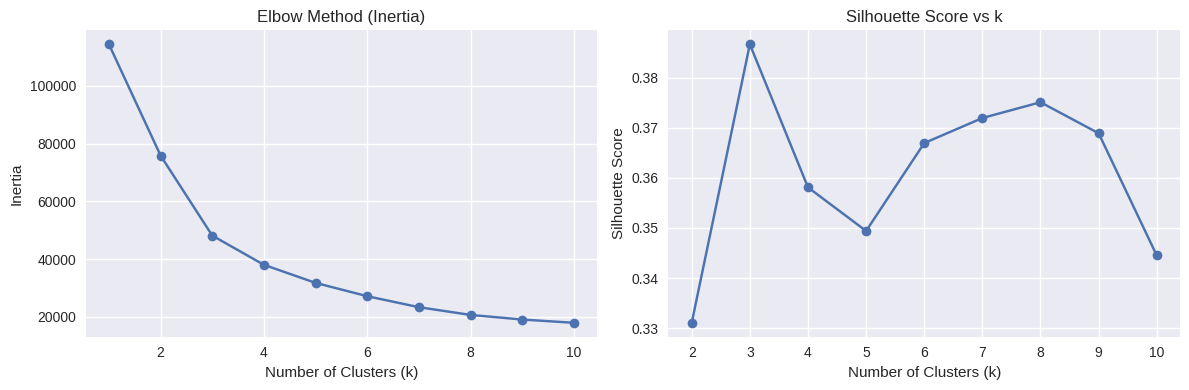

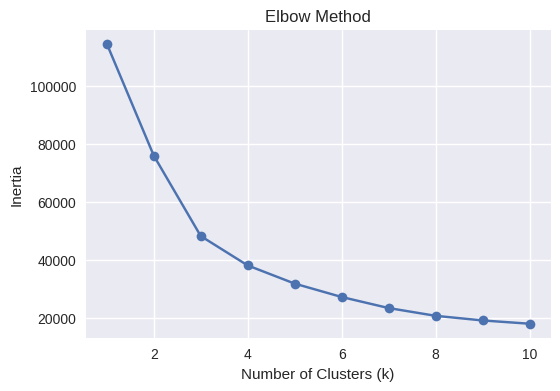

/tmp/ipython-input-1652478475.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(silhouette_box_data, labels=unique)


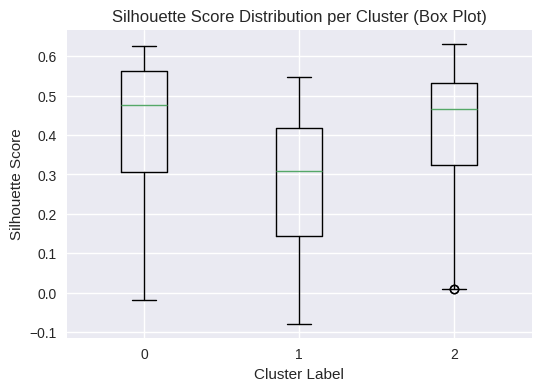

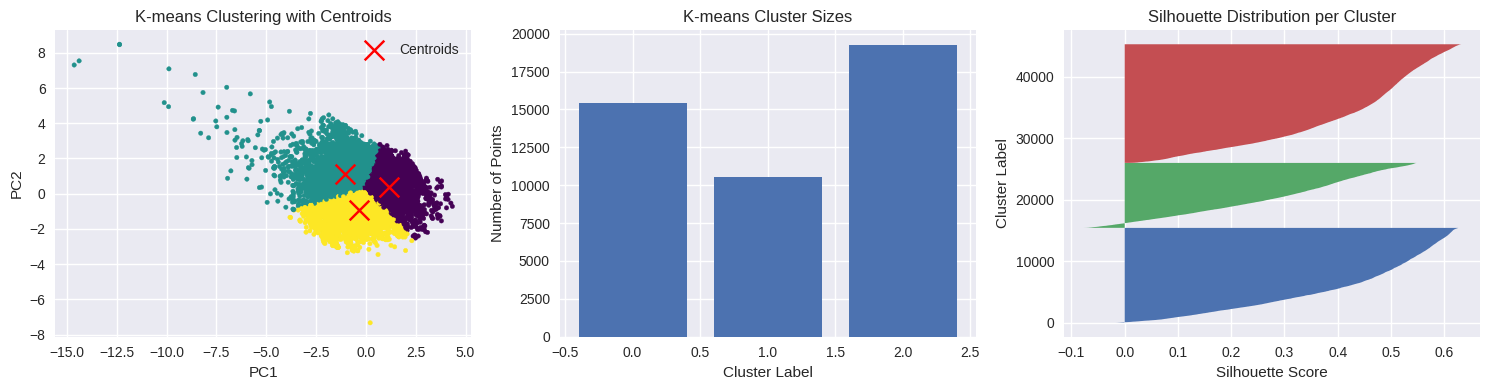


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [21]:
# ========= 1. Inertia (Elbow Method) =========
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia)."""
    inertia = 0
    for k in range(len(centroids)):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[k]) ** 2)
    return inertia


fig, axs = plt.subplots(1, 2, figsize=(12,4))

# Inertia Plot
axs[0].plot(range(1, len(inertias)+1), inertias, marker='o')
axs[0].set_title("Elbow Method (Inertia)")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Inertia")
axs[0].grid(True)

# Silhouette Plot
K = range(2, len(sil_scores)+2)  # To align k values
axs[1].plot(K, sil_scores, marker='o')
axs[1].set_title("Silhouette Score vs k")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Silhouette Score")
axs[1].grid(True)

plt.tight_layout()
plt.show()



inertias = plot_elbow_curve(X_pca)



# ===== Silhouette Box Plot (Required for Screenshot) =====
plt.figure(figsize=(6,4))
silhouette_box_data = [sil_values[labels == cluster] for cluster in unique]

plt.boxplot(silhouette_box_data, labels=unique)
plt.xlabel("Cluster Label")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Distribution per Cluster (Box Plot)")
plt.grid(True)
plt.show()



# ========= 3. Final K-Means (3 Required Plots) =========
kmeans = KMeansClustering(n_clusters=3)
kmeans.fit(X_pca)
labels = kmeans.labels
centroids = kmeans.centroids

from sklearn.metrics import silhouette_samples
sil_values = silhouette_samples(X_pca, labels)

plt.figure(figsize=(15, 4))

# Scatter + Centroids
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title("K-means Clustering with Centroids")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# Cluster Sizes
plt.subplot(1, 3, 2)
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.title("K-means Cluster Sizes")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")

# Silhouette Distribution
plt.subplot(1, 3, 3)
y_lower = 10
for cluster in unique:
    cluster_sil = sil_values[labels == cluster]
    cluster_sil.sort()
    size = len(cluster_sil)
    y_upper = y_lower + size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil)
    y_lower = y_upper + 10
plt.title("Silhouette Distribution per Cluster")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster Label")

plt.tight_layout()
plt.show()


# ========= Final Metrics Print =========
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")


## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

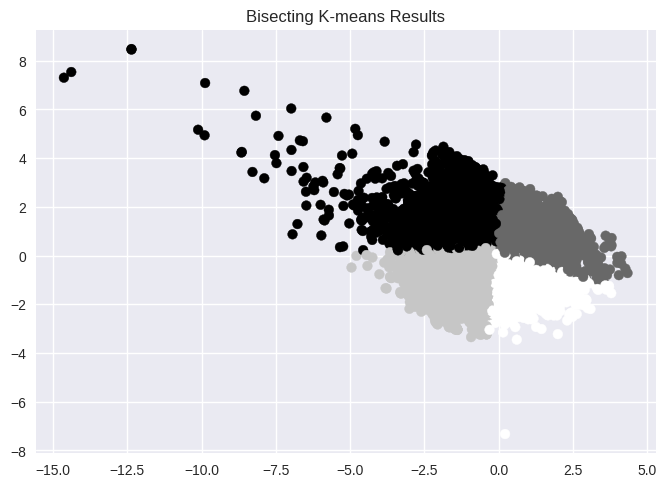

In [15]:
from sklearn.cluster import KMeans
import numpy as np

class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm.

    Students should implement `fit_predict` to recursively split clusters until
    `n_clusters` is reached.
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        # Optional: store mapping parent -> (left_label, right_label)
        self.split_tree = {}
        # Optional: store centroids per cluster id
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached.

        TODO (student):
        - Start with all points assigned to label 0.
        - While number of unique labels < n_clusters:
            - Select a cluster to split (e.g., the largest cluster by size)
            - Run a binary KMeans (k=2) on the points in that cluster
            - Assign new labels (keep one child label as the original, give the other a new id)
            - Record parent -> (left, right) in `self.split_tree` and centroids in `self.centers_`
        - Set and return `self.labels_` (numpy array of length n_samples)

        Hints:
        - Use sklearn.cluster.KMeans(n_clusters=2, random_state=self.random_state) for the split step
        - Keep a counter for new label ids and increment when creating a new cluster
        - Use boolean indexing to operate on subsets of X efficiently
        """
        n_samples = len(X)
        self.labels_ = np.zeros(n_samples, dtype=int)  # Start with cluster 0
        current_clusters = 1
        next_label = 1  # Next available label

        while current_clusters < self.n_clusters:
            # Find largest cluster to split
            cluster_sizes = np.bincount(self.labels_)
            cluster_to_split = np.argmax(cluster_sizes)

            # Get points in that cluster
            mask = self.labels_ == cluster_to_split
            sub_X = X[mask]

            if len(sub_X) < 2:
                break  # Can't split

            # Binary K-means
            kmeans = KMeans(n_clusters=2, random_state=self.random_state)
            sub_labels = kmeans.fit_predict(sub_X)

            # Assign new labels: keep 0 as original, 1 as new
            new_mask = sub_labels == 1
            self.labels_[mask] = np.where(new_mask, next_label, cluster_to_split)

            # Record split
            self.split_tree[cluster_to_split] = (cluster_to_split, next_label)

            # Centroids
            self.centers_[cluster_to_split] = kmeans.cluster_centers_[0]
            self.centers_[next_label] = kmeans.cluster_centers_[1]

            next_label += 1
            current_clusters += 1

        return self.labels_

# Example usage (run to test)
bisect = BisectingKMeans(n_clusters=4)
labels = bisect.fit_predict(X_pca)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.title('Bisecting K-means Results')
plt.show()

## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!